### Importing Libraries

In [1]:
import numpy as np
import keras
import tensorflow as tf
from tensorflow.keras import layers
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split
from kerastuner import RandomSearch
import matplotlib.pyplot as plot
from keras.utils import np_utils
import pandas as pd

from IPython.display import display
import time
from tqdm import tqdm

C:\Users\surya\AppData\Local\Temp\ipykernel_20268\1359375856.py:11: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


# Global Random Search using AdamOptimiser

In [2]:
num_classes = 10
input_shape = (28, 28, 1)

(x_train, y_train), (x_test, y_test) = mnist.load_data()

n=30000
x_train = x_train[1:n]
y_train=y_train[1:n]

x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [3]:
def create_Global_Random_Adam_model(parameters):
    
    selectedLearningRate = parameters.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    selectedBatchSize = parameters.Choice('batch_size',values= [32,64,96,128])
    selectedBeta1 = parameters.Choice('beta_1',values= [0.25,0.5,0.9])
    selectedBeta2 = parameters.Choice('beta_2',values= [0.9,0.99,0.999])
   
    model = keras.Sequential(
        [
            keras.Input(shape=(28, 28, 1)),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation="softmax"),
        ]
    )
    
    optimizer = Adam(learning_rate=selectedLearningRate, beta_1=selectedBeta1, beta_2=selectedBeta2)
    
    model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

    return model

In [4]:
globalRandomSearch_Adam_optimiser = RandomSearch(
                        create_Global_Random_Adam_model,
                        objective = 'val_loss',
                        seed = 42,
                        max_trials=20,
                        directory = 'GlobalRandomSearch_Adam',
                        project_name = 'mnist_data'
                    )


In [5]:
start_time = time.time()
globalRandomSearch_Adam_optimiser.search(x_train, y_train, validation_data = (x_validation, y_validation), epochs = 10)
end_time = time.time()
print(f'\n\nTotal time to execute Global Random Search(Adam) is : {end_time - start_time} seconds')

Trial 20 Complete [00h 00m 42s]
val_loss: 0.04683544486761093

Best val_loss So Far: 0.042412642389535904
Total elapsed time: 00h 14m 27s
INFO:tensorflow:Oracle triggered exit


Total time to execute Global Random Search(Adam) is : 867.4592354297638 seconds


In [6]:
globalRandomSearch_Adam_param_values = globalRandomSearch_Adam_optimiser.oracle.trials.values()

trainingLoss_data = []
validationLoss_data = []
bestTrainingLoss_data = []
bestValidationLoss_data = []

currentBestTrainingLoss = currentBestValidationLoss = float("inf")


parameters = []
counter = 1

for parameter in globalRandomSearch_Adam_param_values:
    trainingLoss = parameter.metrics.get_history('loss')[-1].value[0]
    validationLoss = parameter.metrics.get_history('val_loss')[-1].value[0]
    trainingAccuracy = parameter.metrics.get_history('accuracy')[-1].value[0]
    validationAccuracy = parameter.metrics.get_history('val_accuracy')[-1].value[0]
    trainingLoss_data.append(trainingLoss)
    validationLoss_data.append(validationLoss)
    
    parameter_dictionary = {
        "Trial": counter,
        "Learning Rate": parameter.hyperparameters.get("learning_rate"),
        "Batch Size": parameter.hyperparameters.get("batch_size"),
        "Beta 1": parameter.hyperparameters.get("beta_1"),
        "Beta 2": parameter.hyperparameters.get("beta_2"),
        "Training Accuracy": trainingAccuracy,
        "Validation Accuracy": validationAccuracy,
        "Training Loss": trainingLoss,
        "Validation Loss": validationLoss
    }
    
    if validationLoss < currentBestValidationLoss:
        currentBestValidationLoss = validationLoss
    
    if trainingLoss < currentBestTrainingLoss:
        currentBestTrainingLoss = trainingLoss
    
    bestTrainingLoss_data.append(currentBestTrainingLoss)
    bestValidationLoss_data.append(currentBestValidationLoss)
    
    parameters.append(parameter_dictionary)
    counter += 1

globalRandomSearch_Adam_Parameters_df = pd.DataFrame(parameters)


In [7]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
display(globalRandomSearch_Adam_Parameters_df)


,Trial,Learning Rate,Batch Size,Beta 1,Beta 2,Training Accuracy,Validation Accuracy,Training Loss,Validation Loss
0,1,0.001900,32,0.50,0.900,0.985749,0.987667,0.048295,0.044479
1,2,0.005978,64,0.50,0.900,0.977666,0.984333,0.079558,0.062042
2,3,0.000989,32,0.90,0.990,0.987499,0.987500,0.037290,0.042971
3,4,0.006719,32,0.90,0.900,0.976624,0.983333,0.089478,0.056145
4,5,0.001450,32,0.25,0.990,0.986666,0.986667,0.041790,0.042413
5,6,0.007178,64,0.50,0.990,0.977374,0.985667,0.074202,0.052586
6,7,0.000139,32,0.90,0.999,0.969665,0.974833,0.101611,0.085779
7,8,0.006600,64,0.25,0.900,0.972374,0.980167,0.097719,0.060581
8,9,0.005242,64,0.50,0.999,0.982124,0.986167,0.058160,0.047235
9,10,0.004256,32,0.25,0.990,0.983333,0.988000,0.056603,0.050256


In [8]:
testLoss_data = []
bestTestLoss_data = []
currentBestTestLoss = float("inf")
optimisedParameters = {}

counter = 1

for parameter in tqdm(globalRandomSearch_Adam_param_values):
    
    model = keras.Sequential(
        [
            keras.Input(shape=(28, 28, 1)),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation="softmax"),
        ]
    )
    
    optimizer = Adam(learning_rate=parameter.hyperparameters.get('learning_rate'), beta_1=parameter.hyperparameters.get('beta_1'), beta_2=parameter.hyperparameters.get('beta_2'))
    
    model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

    model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size = parameter.hyperparameters.get('batch_size'), epochs = 10, verbose=0)
    testLoss, testAccuracy = model.evaluate(x_test, y_test, verbose=0)
    testLoss_data.append(testLoss)
    
    if testLoss < currentBestTestLoss:
        currentBestTestLoss = testLoss
        optimisedParameters = {
                                    "Trial": counter,
                                    "Learning Rate": parameter.hyperparameters.get("learning_rate"),
                                    "Batch Size": parameter.hyperparameters.get("batch_size"),
                                    "Beta 1": parameter.hyperparameters.get("beta_1"),
                                    "Beta 2": parameter.hyperparameters.get("beta_2"),
                                    "Test Accuracy": testAccuracy,
                                    "Test Loss": testLoss
                              }
    bestTestLoss_data.append(currentBestTestLoss)
        
    counter += 1
    

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [07:31<00:00, 22.59s/it]


In [9]:
globalRandomSearch_Adam_Test_Parameters_df = pd.DataFrame([optimisedParameters])
display(globalRandomSearch_Adam_Test_Parameters_df)

,Trial,Learning Rate,Batch Size,Beta 1,Beta 2,Test Accuracy,Test Loss
0,3,0.000989,32,0.9,0.99,0.9888,0.032592


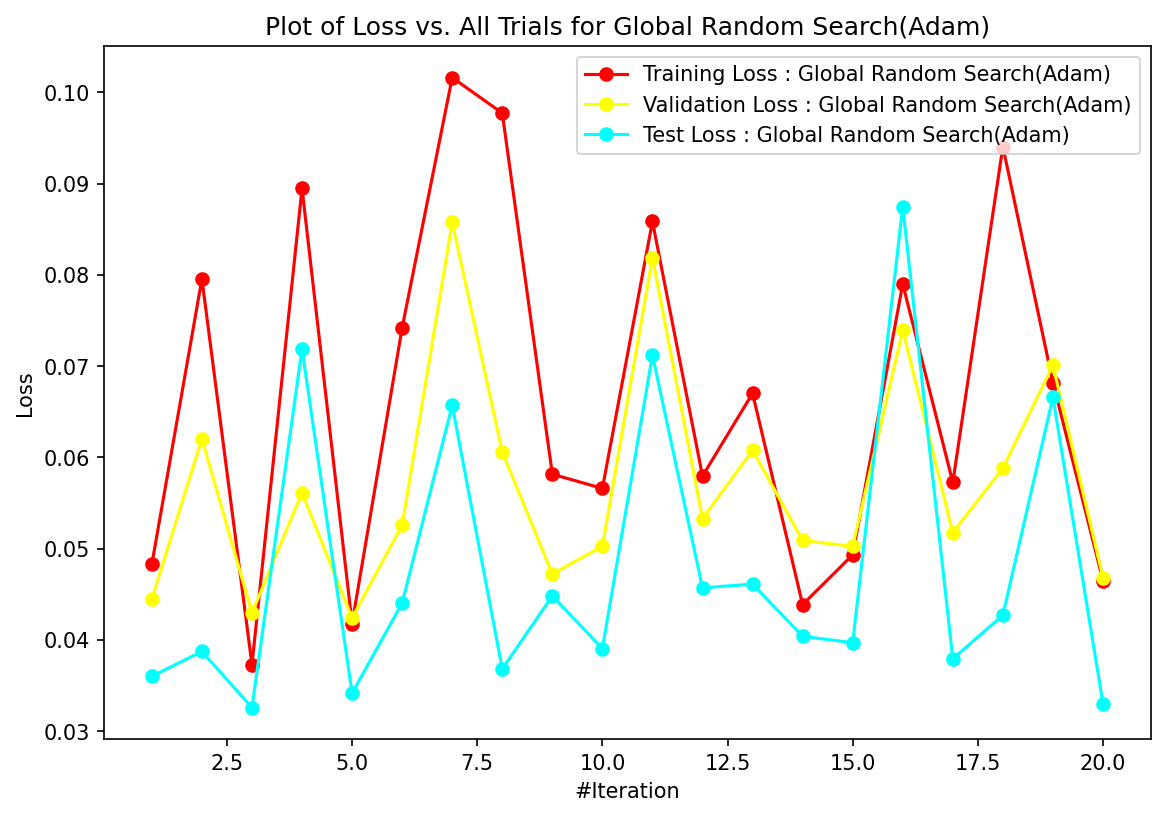

In [10]:
plot.figure(figsize=(9, 6), dpi=150)     
plot.plot(range(1, len(globalRandomSearch_Adam_param_values) + 1), trainingLoss_data, label="Training Loss : Global Random Search(Adam)", marker='o', color="Red")
plot.plot(range(1, len(globalRandomSearch_Adam_param_values) + 1), validationLoss_data, label="Validation Loss : Global Random Search(Adam)", marker='o', color="Yellow")
plot.plot(range(1, len(globalRandomSearch_Adam_param_values) + 1), testLoss_data, label="Test Loss : Global Random Search(Adam)", marker='o', color="Cyan")
plot.xlabel("#Iteration")
plot.ylabel("Loss")
plot.title('Plot of Loss vs. All Trials for Global Random Search(Adam)')
plot.legend()
plot.show()

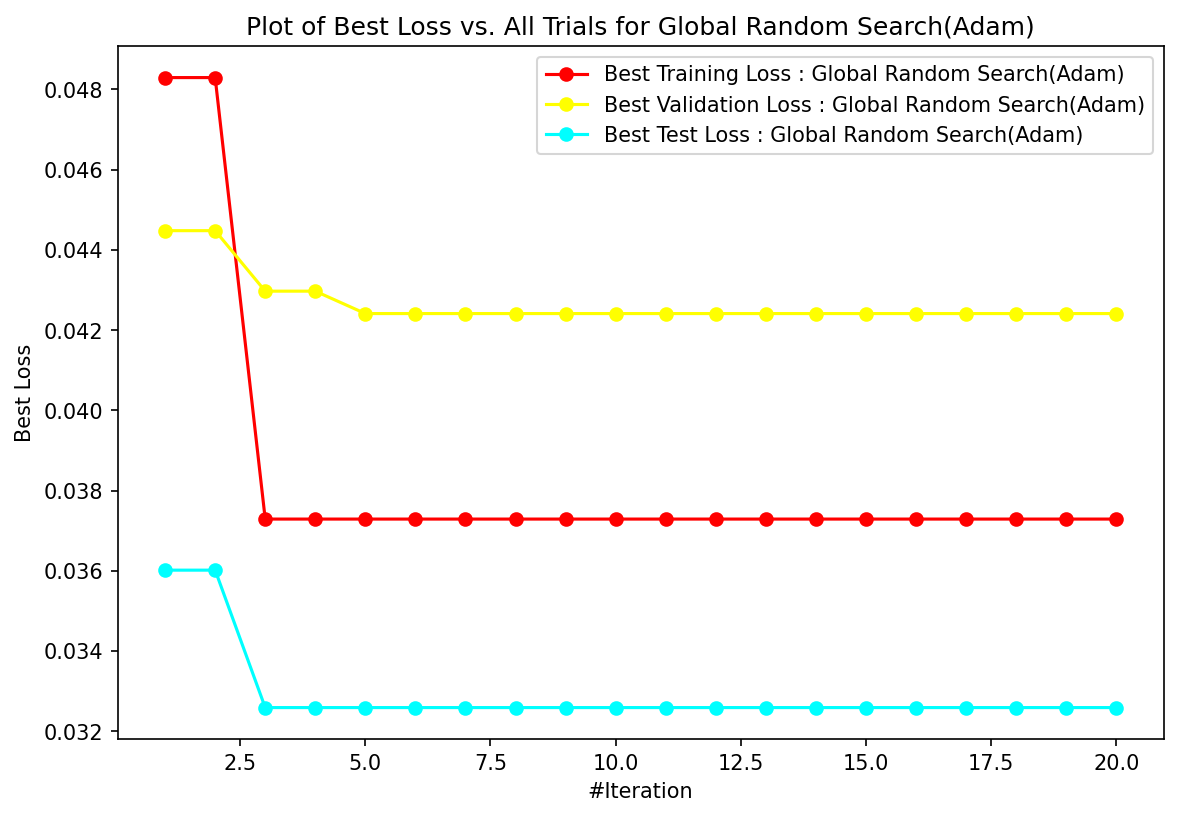

In [11]:
plot.figure(figsize=(9, 6), dpi=150)     
plot.plot(range(1, len(globalRandomSearch_Adam_param_values) + 1), bestTrainingLoss_data, label="Best Training Loss : Global Random Search(Adam)", marker='o', color="Red")
plot.plot(range(1, len(globalRandomSearch_Adam_param_values) + 1), bestValidationLoss_data, label="Best Validation Loss : Global Random Search(Adam)", marker='o', color="Yellow")
plot.plot(range(1, len(globalRandomSearch_Adam_param_values) + 1), bestTestLoss_data, label="Best Test Loss : Global Random Search(Adam)", marker='o', color="Cyan")
plot.xlabel("#Iteration")
plot.ylabel("Best Loss")
plot.title('Plot of Best Loss vs. All Trials for Global Random Search(Adam)')
plot.legend()
plot.show()

In [12]:
bestTest_GRS_Adam_DF = pd.DataFrame(bestTestLoss_data, columns=['BestTestLoss_GRS_Adam'])
bestTest_GRS_Adam_DF.to_csv('GlobalRandomSearch_Adam_BestTestLoss.csv', index=False)